# Brief tour of jax_morph modules

## datastructures

`CellState`:

Dataclass containing all of the attributes defining the system's state.

`SpaceFunc`:

Dataclass meant to store space-handling functions. Usually `displacement` and `shift` functions created from jax_md.space or equivalent.

## simulation

Core of the jax-morph library.

`simulation`:

Given the list of substep functions as input, generates the init-apply functions to be used to initialize and advance the simulation one step at a time.


`sim_trajectory`:

Given the init-apply functions generated by the *simulation* function and an initial state, performs an entire simulation and returns the final state of the trajectory.


**NOTE:**
For more datailed information regarding how to manage **randomness**, and in particular the generation of trajectories with different random keys, take a look at the section [Randomness (key injection)](##randomness-(key-injection)) below.

### Customization of simulation substeps

The functions called in sequence at every simulation step (i.e. substeps) **must** satisfy the following requirements:

- The first function of the list **must** be the function performing the sampling step (in our case the cell division step) and must follow the function signature `CellDivision_fn` defined below. In particular it must return both the new `CellState` and the log of the probability of the performed (sampled) action. **This function must always be present.** If no sampling step is required, define an empty function with the `CellDivision_fn` signature and pass it as first of the list.

- The subsequent functions will be called in the given order and must follow the function signature `SimSubstep_fn` defined below.

There is no limit to the number of `SimSubstep_fn` functions that can be called after the first mandatory `CellDivision_fn` function.

**Best practice suggestion:** I found it useful to prepend `S_` to all of the functions that follow one of the signatures below, i.e. all of the functions that return an updated version of `CellState`.

    CellDivision_fn = Callable[
                            [CellState,ParamsDict,SpaceFunc], 
                            tuple[CellState, np.floating]
                            ]

    SimSubstep_fn = Callable[
                            [CellState,ParamsDict,SpaceFunc], 
                            CellState
                            ]

## cell_division

`S_cell_division`:

Performs one single cell division step. The probability of cell division is determined by the (normalized) division rates that are stored in `CellState`. Every factor affecting the probability of division of a cell (radius, chemicals, stress, even cell existence itself) must be taken into account in a **separate function** that handles the calculation of the division rates.

## cell_growth

`S_grow_cells`:

Exponentially grows the radius of every cell in the simulation with a fixed growth rate (default = .1).

- Radius is clipped to a max radius set in the parameters dictionary.

- Assumes that inexistent cells have radius = 0.

## mechmin

`mechmin_sgd`:

Performs minimization with SGD of an arbitrary jax_md.energy function passed as argument. Step size is fixed and can be passed as argument (default dt = .001). Number of minimization steps is read from the parameters dictionary ('mech_relaxation_steps'). Returns the position of the spheres after minimization.

It is agnostic both of the precise form of the energy function (morse, soft sphere, ...) and of their specific parameters.

**NOTE:**

- This is **NOT** a state-updating function!

- It is a useful utility function to embed in a custom state-updating function, where information about the precise functional form of the energy function and of its parameters can be more easily embedded.

## diffusion

(Technically wrong since the system is not 1D, but for the moment we use this.)

Calculates the new chemical concentrations at each spatial site assuming steady-state 1D diffusion (D) with degradation (K) (production and degradation continuous in time at the secretion site).


$$ \frac{d^2}{dr^2} c(r) - K c (r) = 0$$

with solution:

$$c(r)= \frac{Source}{2 \sqrt{DK}} exp({-\sqrt{\frac{K}{D}} r)}$$

which gives (at x=0):

$$ c_{max} = \frac{Source}{2 \sqrt{DK}} $$


`S_chem_diffusion`:

Calculates the new chemical concentrations at each spatial site by diffusing the concentrations read from state.chemical with the *diffuse_allchem* function defined below. (*Not actually used in the simulations for the moment.*)


`diffuse_allchem`:

Calculates the new chemical concentrations at each spatial site by diffusing the secretion rates passed as first argument. **Not** a state-updating function, returns the array of the new chemical concentrations at each site.

Useful also in the calculation of the steady state of the secretion-diffusion process, allows to update the system state only once at the end of the calculation.

## utils

Various helpful functions.

`logistic`:

Calculates a logistic function of the input with the given parameters.

## visualization

Plotting utility finctions for a fast visualization of the system state with matplotlib.

`draw_circles_ctype`:

Draws cell, colored by state.celltype (only works for 1 or 2 different celltypes).


`draw_circles_chem`:

Draws cell, colored by state.chemical. The chemical the concentration of which shall be used to color cells can be specified as argument.


`draw_circles_divrate`:

Draws cell, colored by state.divrate.

# Basic simulation tutorial

## Imports

In [1]:
import jax.numpy as np

from jax.random import split, PRNGKey

from jax.config import config
config.update('jax_debug_nans', True)

### NOTE: f32 gives > 3x speedup wrt f64
#config.update('jax_enable_x64', True)

In [2]:
from jax_md import space

In [3]:
import jax_morph

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate

from jax_morph.datastructures import CellState, SpaceFunc
from jax_morph.simulation import simulation, sim_trajectory

from jax_morph.cell_division import S_cell_division
from jax_morph.cell_growth import S_grow_cells

from chem_twotypes.mechanical import S_mechmin_twotypes
from chem_twotypes.secdiff import S_ss_chemfield
from chem_twotypes.divrates import S_set_divrate

from chem_twotypes.initial_states import init_state_grow

In [4]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.9'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [5]:
import matplotlib.pyplot as plt

from tqdm import tqdm

## Set Parameters

In [6]:
ParamsDict = dict

In [7]:
# Define parameters -- blue particles are type 1, orange are type 2
# keep jax type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2


### CELL DIMENSIONS

#change constants in divrate calculation if cellRad != .5 
# always use python scalars
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

#possibly different diffusion and degradation for each chemical
diffCoeff = np.ones(n_chem) #np.array([1.,1.])
degRate = np.ones(n_chem) #np.array([1.,1.])

#diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5


### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = sec_max_unitary*np.ones((n_chem,), dtype=np.float32)
#sec_max = sec_max.at[0].set(10)

sec_gamma = 1.* np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
sec_k = 0.*np.ones((n_chem,n_chem), dtype=np.float32) 


# DIVISION

div_gamma = 1.*np.ones(n_chem, dtype=np.float32)
div_k = 2.*np.ones(n_chem, dtype=np.float32)
#div_k = div_k.at[0].set(5.)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
eps_TwoTwo = 2. #orange
eps_OneOne = 2. #blue
eps_OneTwo = 2. 

#morse cutoff
r_cutoff = 4.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for Morse potential minimization
mech_relaxation_steps = 100


# Initialization and number of added cells. 
ncells_init = 10 #number of cells in the initial cluster
n_ones_init = 5 #number of type-1 cell in the initail cluster
ncells_add = 300
#ncells_tot =  np.int16(ncells_init+ncells_add)# final number of cells

assert ncells_init > n_ones_init

In [8]:
def _maybe_array(name, value, train_params):
    if train_params[name]:
        return np.array(value)
    else:
        return value

In [9]:
train_params = {
    'n_chem': False,
    
    'sec_max': False,
    'sec_gamma': False,
    'sec_k' : False,
    
    'div_gamma' : False,
    'div_k' : True,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : False,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_TwoTwo': False, 
    'eps_OneOne' : False,
    'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    #'ncells_tot': ncells_tot,
    'ncells_add': False,
}

In [10]:
params = {
    'n_chem': n_chem,
    
    'sec_max': sec_max,
    'sec_gamma': sec_gamma,
    'sec_k' : sec_k,
    
    'div_gamma' : div_gamma,
    'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    #'ncells_tot': ncells_tot,
    'ncells_add': ncells_add,
}

## Simulation

In [11]:
key = PRNGKey(0)

### Generate initial state

In [12]:
# build initial state and space handling functions

fspace = SpaceFunc(*space.free())

key, init_key = split(key)

# generate initial state by growing from single cell
istate = init_state_grow(init_key, params, fspace)

/home/fmottes/.conda/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, name)


### Generate init-apply functions

In [13]:
# functions in this list will be executed in the given order
# at each simulation step
fstep = [
    S_cell_division,
    S_grow_cells,
    S_mechmin_twotypes,
    S_ss_chemfield,
    S_set_divrate
]

sim_init, sim_step = simulation(fstep, params, fspace)

### Step-by-step simulation

`sim_step` performs a single simulation step, slower but can be useful for logging or debugging.

In [14]:
#initialize simulation state 
state = sim_init(istate)

# advance 5 steps in the simulation
logps = []
for i in tqdm(list(range(5))):
    state, logp = sim_step(state)
    logps.append(float(logp))

100%|██████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


In [15]:
logps

[-2.3433775901794434,
 -2.2666497230529785,
 -2.163062334060669,
 -2.518143653869629,
 -2.729310989379883]

In [28]:
state.celltype[:50]

DeviceArray([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0.], dtype=float32)

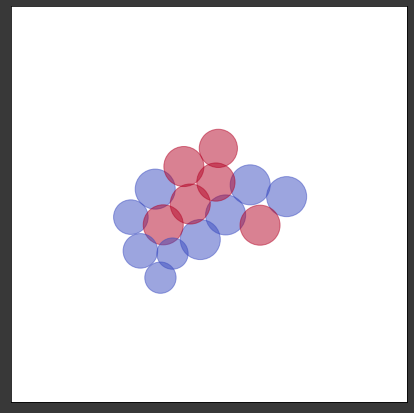

In [17]:
draw_circles_ctype(state);

### Run entire simulation

NOTE: state initialization is carried out automatically inside the `sim_trajectory` function, no need to initialize in this case!

In [18]:
%%time

# run entire simulation
fstate, logps = sim_trajectory(istate, sim_init, sim_step)

CPU times: user 4.31 s, sys: 716 ms, total: 5.02 s
Wall time: 2.61 s


In [27]:
fstate.celltype[:50]

DeviceArray([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 1., 1., 2., 1., 1.,
             2., 1., 1., 2., 2., 1., 2., 2., 2., 1., 1., 1., 2., 1., 2.,
             2., 1., 1., 2., 2., 2., 2., 2., 1., 2., 1., 2., 1., 2., 2.,
             1., 2., 1., 1., 2.], dtype=float32)

In [20]:
logps[:10]

DeviceArray([-2.3433776, -2.2666497, -2.1630623, -2.5181437, -2.7293108,
             -2.5019965, -2.651203 , -2.6209009, -2.4849524, -3.2148879],            dtype=float32)

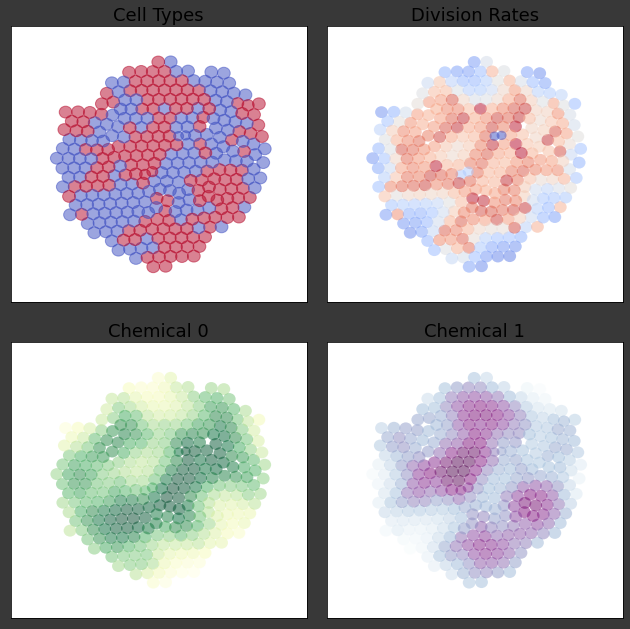

In [21]:
ax1 = plt.subplot(221)
draw_circles_ctype(fstate, ax1)
ax1.set_title('Cell Types');

ax2 = plt.subplot(222)
draw_circles_divrate(fstate, ax2)
ax2.set_title('Division Rates');

ax3 = plt.subplot(223)
draw_circles_chem(fstate, 0, ax3)
ax3.set_title('Chemical 0');

ax4 = plt.subplot(224)
draw_circles_chem(fstate, 1, ax4)
ax4.set_title('Chemical 1');

plt.gcf().set_size_inches(9, 9)
plt.gcf().tight_layout()

## Randomness (key injection)

 - The simulation process consumes and replaces the key that is stored in the CellState.
 - The **default** behavior (shown in the above section) is to keep using the key that is packed in the initial state provided at initialization.
 
A new key that shall be used throughout an entire simulation can be injected:
- at initialization (if using the explicit step-by-step simulation process)
- directly to the simulation function (if running the entire simulation at once)

### At initialization time

In [22]:
#generate new key
key, subkey = split(key)

#inject key at initialization time
state = sim_init(istate, key=subkey)

#run simulation steps as usual (inital state is always the same)

# advance 5 steps into the simulation
for i in tqdm(list(range(5))):
    state, logp = sim_step(state)

100%|██████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


### At simulation time

In [23]:
#generate new key
key, subkey = split(key)

# run entire simulation with new key and same initial state
fstate, logps = sim_trajectory(istate, sim_init, sim_step, key=subkey)

In [25]:
fstate.celltype[:50]

DeviceArray([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 1., 1., 2., 1., 1.,
             2., 1., 1., 2., 2., 1., 2., 2., 2., 1., 1., 1., 2., 1., 2.,
             2., 1., 1., 2., 2., 2., 2., 2., 1., 2., 1., 2., 1., 2., 2.,
             1., 2., 1., 1., 2.], dtype=float32)